In [1]:
# ==============================================================================
# CONFIGURACIÓN INICIAL Y RUTAS
# ==============================================================================
import sys
import os
import pandas as pd
import warnings
import plotly.express as px
import math

warnings.filterwarnings('ignore')


current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

import fn
import fn.plotting as plot_lib 

logger = fn.setup_logger()
logger.info(f"📍 Ejecutando desde: {current_dir}")
logger.info(f"📂 Raíz del proyecto: {project_root}")

print("✅ Entorno configurado correctamente.")
print(f"   Módulos cargados desde: {project_root}")


2025-12-09 23:56:35,682 - INFO - 📍 Ejecutando desde: c:\Users\JosueJ\Documents\ExamenM1\Notebooks
2025-12-09 23:56:35,682 - INFO - 📂 Raíz del proyecto: c:\Users\JosueJ\Documents\ExamenM1
✅ Entorno configurado correctamente.
   Módulos cargados desde: c:\Users\JosueJ\Documents\ExamenM1


In [2]:
# ==============================================================================
# CARGA DE DATOS
# ==============================================================================
try:
    print("\n[1/7] 📥 Cargando datos crudos...")
    
    datos_dict = fn.load_all_data(logger)
    
    print(f"   Archivos cargados: {list(datos_dict.keys())}")
    
    if 'ratings' not in datos_dict or 'restaurants' not in datos_dict:
        raise ValueError("❌ Faltan archivos críticos (ratings o restaurants).")

except Exception as e:
    logger.error(f"Error en carga: {e}")
    raise e



[1/7] 📥 Cargando datos crudos...
2025-12-09 23:56:35,691 - INFO - Cargando desde: c:\Users\JosueJ\Documents\ExamenM1\datos
2025-12-09 23:56:35,857 - INFO - Cargado: parking (Origen: parking.csv)
2025-12-09 23:56:35,857 - INFO - Cargado: usercuisine (Origen: usercuisine.csv)
2025-12-09 23:56:35,857 - WARNING - Duplicados encontrados para 'restaurants': ['restaurants.csv', 'restaurants.xlsx']
2025-12-09 23:56:35,857 - INFO -  -> Conflicto resuelto: Se usará 'restaurants.csv' bajo la llave 'restaurants'
2025-12-09 23:56:35,857 - INFO - Cargado: ratings (Origen: ratings.csv)
2025-12-09 23:56:35,857 - INFO - Cargado: hours (Origen: hours.csv)
2025-12-09 23:56:35,861 - INFO - Cargado: cuisine (Origen: cuisine.csv)
2025-12-09 23:56:35,861 - INFO - Cargado: userpayment (Origen: userpayment.csv)
2025-12-09 23:56:35,861 - INFO - Cargado: payment_methods (Origen: payment_methods.csv)
2025-12-09 23:56:35,861 - WARNING - Duplicados encontrados para 'users': ['users.csv', 'users.xlsx']
2025-12-09 2


🔬 AUDITORÍA DE CALIDAD DE DATOS (DATA QUALITY CHECK)

📂 TABLA: PARKING | Dimensiones: (702, 2)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,placeID,Continuous,int64,0,0.000000,675,96.150000,132012,135111,133180.950000
1,parking_lot,Categorical,object,0,0.000000,7,1.000000,-,-,-



📂 TABLA: USERCUISINE | Dimensiones: (330, 2)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,userID,Categorical,object,0,0.000000,138,41.820000,-,-,-
1,Rcuisine,Categorical,object,0,0.000000,103,31.210000,-,-,-



📂 TABLA: RESTAURANTS | Dimensiones: (130, 21)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,placeID,Unique Key,int64,0,0.000000,130,100.000000,132560,135109,134012.780000
1,latitude,Continuous,float64,0,0.000000,129,99.230000,18.859803,23.760268,21.860000
2,longitude,Continuous,float64,0,0.000000,129,99.230000,-101.028600,-99.126506,-100.340000
3,the_geom_meter,Unique Key,object,0,0.000000,130,100.000000,-,-,-
4,name,Categorical,object,0,0.000000,129,99.230000,-,-,-
5,address,Categorical,object,0,0.000000,100,76.920000,-,-,-
6,city,Categorical,object,0,0.000000,17,13.080000,-,-,-
7,state,Categorical,object,0,0.000000,13,10.000000,-,-,-
8,country,Categorical,object,0,0.000000,3,2.310000,-,-,-
9,fax,Constant,object,0,0.000000,1,0.770000,-,-,-



📂 TABLA: RATINGS | Dimensiones: (1161, 5)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,userID,Categorical,object,0,0.000000,138,11.890000,-,-,-
1,placeID,Continuous,int64,0,0.000000,130,11.200000,132560,135109,134192.040000
2,rating,Discrete (Numeric),int64,0,0.000000,3,0.260000,0,2,1.200000
3,food_rating,Discrete (Numeric),int64,0,0.000000,3,0.260000,0,2,1.220000
4,service_rating,Discrete (Numeric),int64,0,0.000000,3,0.260000,0,2,1.090000



📂 TABLA: HOURS | Dimensiones: (2339, 3)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,placeID,Continuous,int64,0,0.000000,694,29.670000,132012,135111,133082.310000
1,hours,Categorical,object,0,0.000000,273,11.670000,-,-,-
2,days,Categorical,object,0,0.000000,3,0.130000,-,-,-



📂 TABLA: CUISINE | Dimensiones: (916, 2)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,placeID,Continuous,int64,0,0.000000,769,83.950000,132001,135110,132897.170000
1,Rcuisine,Categorical,object,0,0.000000,59,6.440000,-,-,-



📂 TABLA: USERPAYMENT | Dimensiones: (177, 2)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,userID,Categorical,object,0,0.000000,133,75.140000,-,-,-
1,Upayment,Categorical,object,0,0.000000,5,2.820000,-,-,-



📂 TABLA: PAYMENT_METHODS | Dimensiones: (1314, 2)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,placeID,Continuous,int64,0,0.000000,615,46.800000,132002,135110,133218.740000
1,Rpayment,Categorical,object,0,0.000000,12,0.910000,-,-,-



📂 TABLA: USERS | Dimensiones: (138, 19)


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,userID,Unique Key,object,0,0.000000,138,100.000000,-,-,-
1,latitude,Continuous,float64,0,0.000000,128,92.750000,18.813348,23.771030,21.810000
2,longitude,Continuous,float64,0,0.000000,126,91.300000,-101.054680,-99.067106,-100.290000
3,smoker,Categorical,object,0,0.000000,3,2.170000,-,-,-
4,drink_level,Categorical,object,0,0.000000,3,2.170000,-,-,-
5,dress_preference,Categorical,object,0,0.000000,5,3.620000,-,-,-
6,ambience,Categorical,object,0,0.000000,4,2.900000,-,-,-
7,transport,Categorical,object,0,0.000000,4,2.900000,-,-,-
8,marital_status,Categorical,object,0,0.000000,4,2.900000,-,-,-
9,hijos,Categorical,object,0,0.000000,4,2.900000,-,-,-



🎯 JUSTIFICACIÓN TÉCNICA DE LA VARIABLE OBJETIVO
2025-12-09 23:56:36,142 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-09 23:56:36,147 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


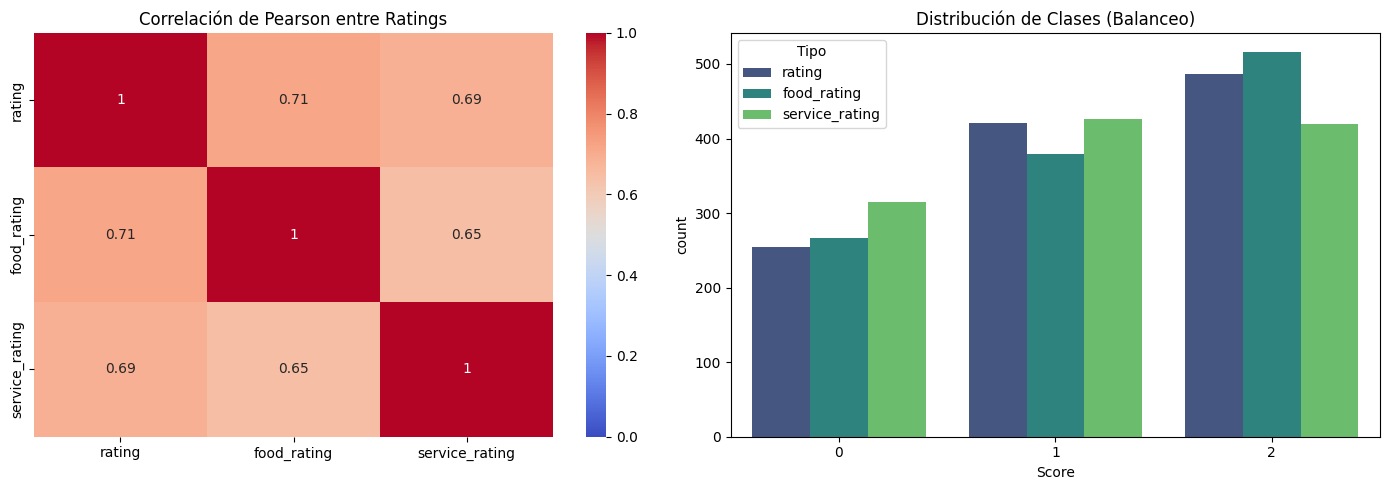

✅ EVIDENCIA 1 (Redundancia): Existe alta correlación positiva entre los ratings.
   Seleccionar 'rating' (general) es suficiente para capturar la tendencia global.

🕵️ Validación de Integridad Referencial:
   -> Usuarios en Ratings sin perfil en Users: 0 (0.00%)
   -> Restaurantes en Ratings sin info en Restaurants: 0 (0.00%)

⚖️ Balanceo de Clases (Variable 'rating'):
rating
2    0.418605
1    0.362618
0    0.218777


In [3]:
# ==============================================================================
# AUDITORÍA TÉCNICA Y SELECCIÓN DE VARIABLE OBJETIVO 
# ==============================================================================
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🔬 AUDITORÍA DE CALIDAD DE DATOS (DATA QUALITY CHECK)")


for nombre_tabla, df_temp in datos_dict.items():
    print(f"\n{'='*60}")
    print(f"📂 TABLA: {nombre_tabla.upper()} | Dimensiones: {df_temp.shape}")
    print(f"{'='*60}")
    
    # Generamos la matriz usando nuestra función de utils
    quality_matrix = fn.utils.get_data_quality_report(df_temp)
    

    display(quality_matrix.style.background_gradient(cmap='Reds', subset=['Missing_(%)'])
                           .background_gradient(cmap='Blues', subset=['Cardinality_(%)']))
    
    constantes = quality_matrix[quality_matrix['Inferred_Type'] == 'Constant (Useless)']['Variable'].tolist()
    if constantes:
        print(f"⚠️  ALERTA: Se detectaron columnas sin varianza: {constantes}")

# ------------------------------------------------------------------
# JUSTIFICACIÓN DE LA SELECCIÓN DE LA VARIABLE OBJETIVO
# ------------------------------------------------------------------
print("\n" + "="*60)
print("🎯 JUSTIFICACIÓN TÉCNICA DE LA VARIABLE OBJETIVO")
print("="*60)

if 'ratings' in datos_dict:
    df_r = datos_dict['ratings']
    
    cols_ratings = ['rating', 'food_rating', 'service_rating']
    if all(c in df_r.columns for c in cols_ratings):
        corr_matrix = df_r[cols_ratings].corr()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, ax=ax1)
        ax1.set_title("Correlación de Pearson entre Ratings")
        
        df_melt = df_r[cols_ratings].melt(var_name='Tipo', value_name='Score')
        sns.countplot(data=df_melt, x='Score', hue='Tipo', ax=ax2, palette='viridis')
        ax2.set_title("Distribución de Clases (Balanceo)")
        
        plt.tight_layout()
        plt.show()
        
        print("✅ EVIDENCIA 1 (Redundancia): Existe alta correlación positiva entre los ratings.")
        print("   Seleccionar 'rating' (general) es suficiente para capturar la tendencia global.")

    # Verificación de Integridad Referencial
    print("\n🕵️ Validación de Integridad Referencial:")
    
    if 'users' in datos_dict:
        ids_r = set(df_r['userID'])
        ids_u = set(datos_dict['users']['userID'])
        missing_users = len(ids_r - ids_u)
        print(f"   -> Usuarios en Ratings sin perfil en Users: {missing_users} ({(missing_users/len(df_r))*100:.2f}%)")
    
    if 'restaurants' in datos_dict:
        ids_r_place = set(df_r['placeID'])
        ids_p = set(datos_dict['restaurants']['placeID'])
        missing_places = len(ids_r_place - ids_p)
        print(f"   -> Restaurantes en Ratings sin info en Restaurants: {missing_places} ({(missing_places/len(df_r))*100:.2f}%)")

    target_counts = df_r['rating'].value_counts(normalize=True)
    print(f"\n⚖️ Balanceo de Clases (Variable 'rating'):")
    print(target_counts.to_string())

else:
    print("❌ No se encontró la tabla 'ratings'.")

In [4]:
# ==============================================================================
# INGENIERÍA DE DATOS 
# ==============================================================================
try:
    print("\n[2/7] ⚙️  Generando Dataset Analítico (Merge y Tipificación)...")
    
    df_master = fn.engineering.generate_analytical_dataset(datos_dict, logger) ## GENERA EL MERGE Y CREA LAS NUEVAS VARIABLES
    
    # 2. AUDITORÍA POST-MERGE
    print("\n   🕵️  Auditoría de Calidad (Post-Merge):")
    print("   Nota: Es normal ver columnas rojas (Missing) aquí, ya que aún no imputamos.")
    
    quality_merge = fn.utils.get_data_quality_report(df_master)
    

    display(quality_merge.style.background_gradient(cmap='Reds', subset=['Missing_(%)'])
                           .format({'Missing_(%)': '{:.2f}%'}))

    
    print("\n   🧠 Verificación de Tipos (IDs deben ser object):")
    cols_check = ['placeID', 'userID', 'user_age']
    print(df_master[cols_check].dtypes)

except Exception as e:
    logger.error(f"Error en ingeniería: {e}")
    raise e


[2/7] ⚙️  Generando Dataset Analítico (Merge y Tipificación)...
2025-12-09 23:56:36,293 - INFO - Iniciando ingeniería de variables y construcción de dataset...
2025-12-09 23:56:36,296 - INFO -    -> Variable creada: num_tipos_cocina.
2025-12-09 23:56:36,299 - INFO -    -> Variable creada: nivel_estacionamiento.
2025-12-09 23:56:36,301 - INFO -    -> Variable creada: dias_abiertos_semana.
2025-12-09 23:56:36,303 - INFO -    -> Variable creada: rating_promedio_historico.
2025-12-09 23:56:36,304 - INFO -    -> Rating unido con variables de ingenieria.
2025-12-09 23:56:36,307 - INFO -    -> Unión realizada con datos de usuarios por userID.
2025-12-09 23:56:36,310 - INFO -    -> Unión realizada con datos de restaurantes por placeID.
2025-12-09 23:56:36,312 - INFO -    -> Variable creada: user_age.
2025-12-09 23:56:36,312 - INFO -    -> Variable objetivo creada: target_exitoso (rating >= 2.0).
2025-12-09 23:56:36,312 - INFO -    -> Columnas redundantes eliminadas (Se conserva 'rating' para 

,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
3,num_tipos_cocina,Discrete (Numeric),float64,288,24.81%,3,0.260000,1.000000,3.000000,1.190000
5,dias_abiertos_semana,Constant,float64,8,0.69%,1,0.090000,3.000000,3.000000,3.000000
0,userID,Categorical,object,0,0.00%,138,11.890000,-,-,-
2,rating,Discrete (Numeric),int64,0,0.00%,3,0.260000,0,2,1.200000
1,placeID,Categorical,object,0,0.00%,130,11.200000,-,-,-
4,nivel_estacionamiento,Discrete (Numeric),int64,0,0.00%,3,0.260000,0,2,0.540000
6,rating_promedio_historico,Continuous,float64,0,0.00%,52,4.480000,0.250000,2.000000,1.200000
7,activity,Categorical,category,0,0.00%,5,0.430000,-,-,-
8,ambience,Categorical,category,0,0.00%,4,0.340000,-,-,-
9,budget,Categorical,category,0,0.00%,4,0.340000,-,-,-



   🧠 Verificación de Tipos (IDs deben ser object):
placeID      object
userID       object
user_age    float64
dtype: object



[3/7] 🧹 Ejecutando Pipeline de Limpieza...

🕵️  DIAGNÓSTICO DE VARIABLES PARA GRAFICAR (Criterio: Numérica + Continua + No ID):
   - rating                    | Únicos: 3    | ❌ DESCARTADA (Pocos únicos (3 <= 10))
   - num_tipos_cocina          | Únicos: 3    | ❌ DESCARTADA (Pocos únicos (3 <= 10))
   - nivel_estacionamiento     | Únicos: 3    | ❌ DESCARTADA (Pocos únicos (3 <= 10))
   - dias_abiertos_semana      | Únicos: 1    | ❌ DESCARTADA (Pocos únicos (1 <= 10))
   - rating_promedio_historico | Únicos: 52   | ✅ SELECCIONADA ()
   - height                    | Únicos: 38   | ✅ SELECCIONADA ()
   - user_latitude             | Únicos: 128  | ✅ SELECCIONADA ()
   - user_longitude            | Únicos: 126  | ✅ SELECCIONADA ()
   - weight                    | Únicos: 49   | ✅ SELECCIONADA ()
   - rest_latitude             | Únicos: 129  | ✅ SELECCIONADA ()
   - rest_longitude            | Únicos: 129  | ✅ SELECCIONADA ()
   - user_age                  | Únicos: 21   | ✅ SELECCIONADA ()

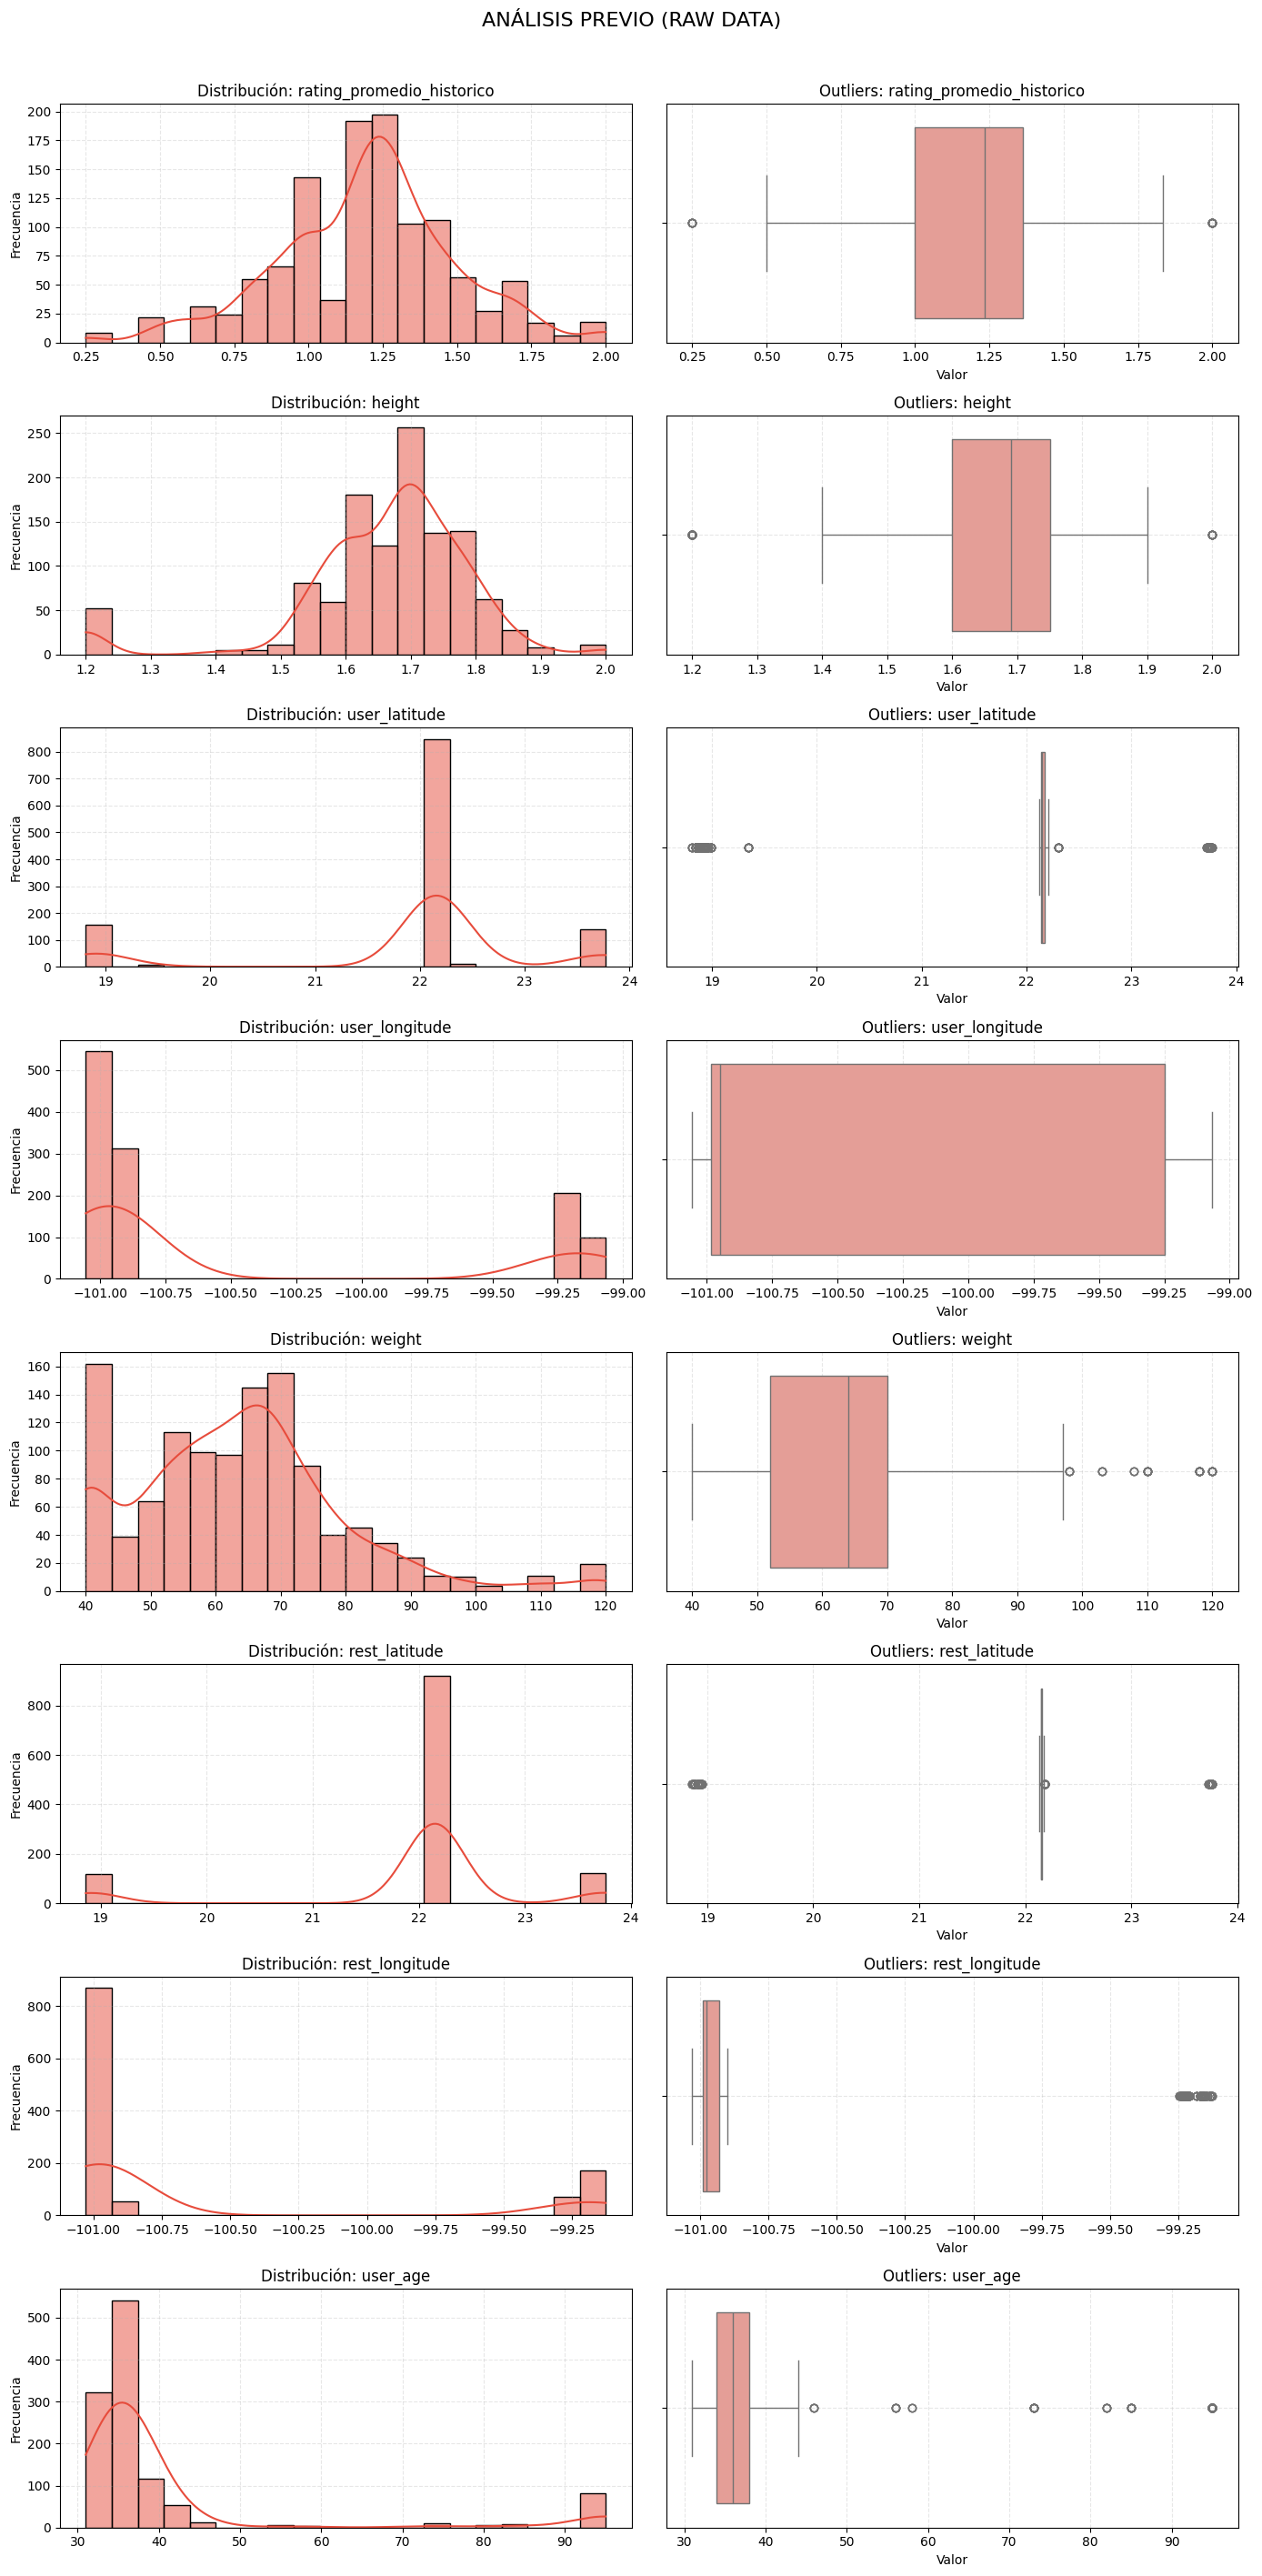


⚙️  Aplicando Normalización, Imputación y Clipping...
2025-12-09 23:56:37,674 - INFO - Normalización de texto aplicada en: ['rest_city', 'rest_state']
2025-12-09 23:56:37,682 - WARNING - 🗑️ Eliminadas por ser Constantes (Varianza 0): ['dias_abiertos_semana', 'fax']
2025-12-09 23:56:37,682 - INFO -    -> Todas las variables cumplen con el criterio de completitud (min 65%).
2025-12-09 23:56:37,682 - INFO - 💉 Iniciando Imputación de Valores Nulos...
2025-12-09 23:56:37,691 - INFO -    -> num_tipos_cocina          | Nulos: 288  | Método: Moda    | Valor: 1.00
2025-12-09 23:56:37,701 - INFO - 🔎 DETALLE DE OUTLIERS (CLIP):
2025-12-09 23:56:37,701 - INFO -    -> rating_promedio_historico: 26 valores ajustados. Límites: (np.float64(0.45), np.float64(1.91))
2025-12-09 23:56:37,707 - INFO -    -> height: 63 valores ajustados. Límites: (np.float64(1.38), np.float64(1.98))
2025-12-09 23:56:37,707 - INFO -    -> user_latitude: 314 valores ajustados. Límites: (np.float64(22.08), np.float64(22.24))


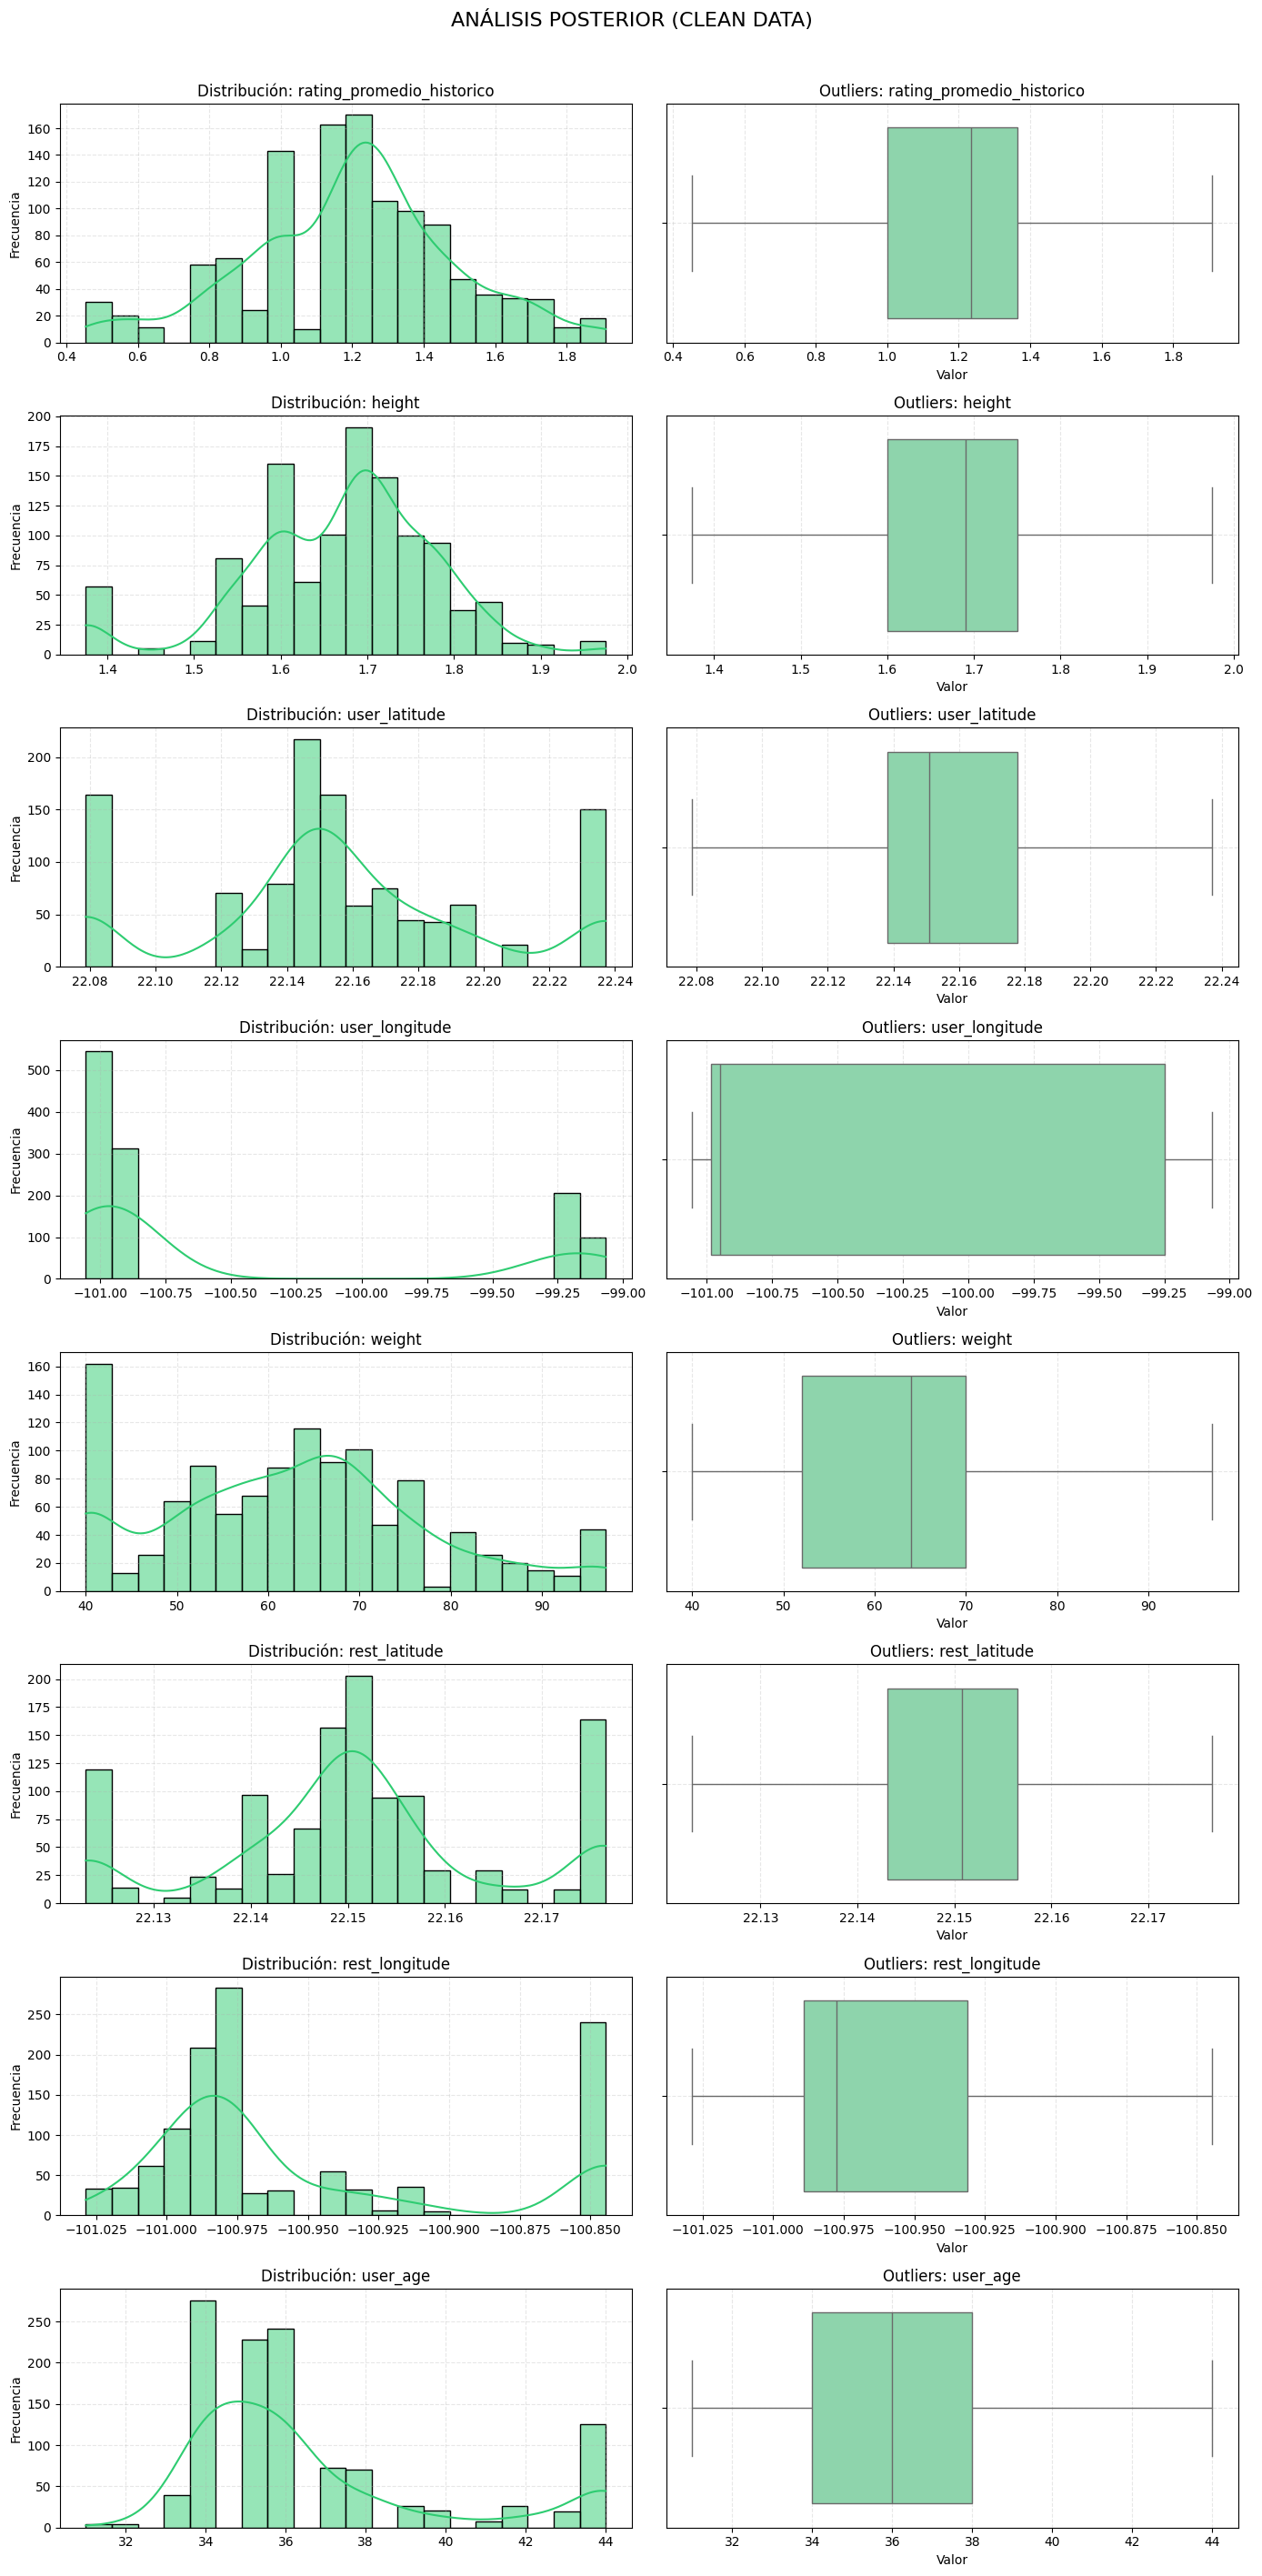


✨ Auditoría Final:


,Variable,Inferred_Type,Dtype,Missing,Missing_(%),Unique,Cardinality_(%),Min,Max,Mean
0,userID,Categorical,object,0,0.0,138,11.89,-,-,-
1,placeID,Categorical,object,0,0.0,130,11.20,-,-,-
2,rating,Discrete (Numeric),int64,0,0.0,3,0.26,0,2,1.2
3,num_tipos_cocina,Discrete (Numeric),float64,0,0.0,3,0.26,1.0,3.0,1.15
4,nivel_estacionamiento,Discrete (Numeric),int64,0,0.0,3,0.26,0,2,0.54
5,rating_promedio_historico,Continuous,float64,0,0.0,52,4.48,0.454545,1.909091,1.2
6,activity,Categorical,category,0,0.0,5,0.43,-,-,-
7,ambience,Categorical,category,0,0.0,4,0.34,-,-,-
8,budget,Categorical,category,0,0.0,4,0.34,-,-,-
9,color,Categorical,category,0,0.0,8,0.69,-,-,-


In [5]:
# ==============================================================================
# LIMPIEZA AVANZADA Y EDA COMPARATIVO (HISTOGRAMAS + BOXPLOTS)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import math
import fn.utils
import fn.cleaning

try:
    print("\n[3/7] 🧹 Ejecutando Pipeline de Limpieza...")

    print("\n🕵️  DIAGNÓSTICO DE VARIABLES PARA GRAFICAR (Criterio: Numérica + Continua + No ID):")
    vars_to_plot = []

    for col in df_master.columns:
        if not pd.api.types.is_numeric_dtype(df_master[col]):
            continue

        n_unique = df_master[col].nunique()
        es_continua = fn.utils.is_continuous(df_master[col])
        es_id = 'ID' in col or 'id' in col
        es_target = 'target' in col or 'exitoso' in col
        
        estado = "❌ DESCARTADA"
        razon = ""

        if es_id: razon = "Es ID"
        elif es_target: razon = "Es Target"
        elif not es_continua: razon = f"Pocos únicos ({n_unique} <= 10)"
        else:
            estado = "✅ SELECCIONADA"
            vars_to_plot.append(col)

        print(f"   - {col:<25} | Únicos: {n_unique:<4} | {estado} ({razon})")

    n_vars = len(vars_to_plot)
    print(f"\n📊 Variables a auditar visualmente ({n_vars}): {vars_to_plot}")


    def plot_variables_grid(df, variables, title, color_hist, color_box):
        if not variables:
            return
            
        n_rows = len(variables)
        plt.figure(figsize=(14, 3.5 * n_rows))
        
        for i, col in enumerate(variables):
            plt.subplot(n_rows, 2, 2*i + 1)
            sns.histplot(df[col], kde=True, color=color_hist, bins=20)
            plt.title(f'Distribución: {col}')
            plt.xlabel("")
            plt.ylabel("Frecuencia")
            plt.grid(True, linestyle='--', alpha=0.3)
            
            plt.subplot(n_rows, 2, 2*i + 2)
            sns.boxplot(x=df[col], color=color_box) 
            plt.title(f'Outliers: {col}')
            plt.xlabel("Valor")
            plt.grid(True, linestyle='--', alpha=0.3)
            
        plt.suptitle(title, fontsize=16, y=1.01) 
        plt.tight_layout()
        plt.show()


    print(f"\n📊 1. Estado ORIGINAL (Crudo) - Antes de Limpieza:")
    if n_vars > 0:
        plot_variables_grid(
            df_master, vars_to_plot, 
            title="ANÁLISIS PREVIO (RAW DATA)", 
            color_hist='#E74C3C', # Rojo Oscuro
            color_box='#F1948A'   # Rojo Claro
        )
    else:
        print("   ⚠️ No se encontraron variables continuas para graficar.")

    # -----------------------------------------------------------
    # EJECUCIÓN DEL PIPELINE DE LIMPIEZA
    # -----------------------------------------------------------
    print("\n⚙️  Aplicando Normalización, Imputación y Clipping...")
    
    df_limpio = fn.cleaning.normalize_text_data(df_master, logger=logger)

    df_limpio = fn.cleaning.clean_data_advanced(df_limpio, logger)
    
    # -----------------------------------------------------------
    # VISUALIZACIÓN POSTERIOR (CLEAN DATA - VERDE)
    # -----------------------------------------------------------
    print(f"\n📊 2. Estado FINAL (Limpio) - Después de Limpieza:")
    if n_vars > 0:
        vars_finales = [v for v in vars_to_plot if v in df_limpio.columns]
        
        plot_variables_grid(
            df_limpio, vars_finales, 
            title="ANÁLISIS POSTERIOR (CLEAN DATA)", 
            color_hist='#2ECC71', 
            color_box='#82E0AA'   
        )

    # -----------------------------------------------------------
    # AUDITORÍA FINAL
    # -----------------------------------------------------------
    print("\n✨ Auditoría Final:")
    quality_final = fn.utils.get_data_quality_report(df_limpio)
    display(quality_final)

except Exception as e:
    logger.error(f"Error en limpieza/EDA: {e}")
    raise e

In [6]:
# ==============================================================================
# DIAGNÓSTICO DE MULTICOLINEALIDAD (HEATMAP)
# ==============================================================================
import plotly.express as px
import numpy as np

try:
    print("\n[Diagnóstico] 🌡️ Generando Mapa de Calor de Correlaciones...")


    cols_corr = [
        c for c in df_limpio.select_dtypes(include=[np.number]).columns 
        if 'ID' not in c and 'target' not in c
    ]
    
    if len(cols_corr) < 2:
        print("⚠️ No hay suficientes variables numéricas para correlacionar.")
    else:

        corr_matrix = df_limpio[cols_corr].corr().round(2)


        fig = px.imshow(
            corr_matrix,
            text_auto=True,            
            aspect="auto",
            color_continuous_scale='RdBu_r', 
            zmin=-1, zmax=1,           
            title="<b>Mapa de Calor de Correlación de Pearson</b><br><sup>(Rojo/Azul Intenso = Alta Multicolinealidad)</sup>"
        )
        

        fig.update_layout(
            width=900, height=800,
            xaxis_showgrid=False, yaxis_showgrid=False
        )
        fig.show()


        threshold = 0.7 ### UMBRAL DE CORRELACIÓN PARA CONSIDERAR MULTICOLINEALIDAD SEVERA
        print(f"\n🔍 SUGERENCIAS DE ELIMINACIÓN (Umbral > {threshold}):")
        print("   (Si dos variables tienen alta correlación, elimina la que tenga menos sentido de negocio)")
        
        high_corr_pairs = []
        cols = corr_matrix.columns
        
  
        for i in range(len(cols)):
            for j in range(i+1, len(cols)):
                val = corr_matrix.iloc[i, j]
                if abs(val) >= threshold:
                    high_corr_pairs.append((cols[i], cols[j], val))
        
        if high_corr_pairs:
            high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
            
            for v1, v2, corr in high_corr_pairs:
                print(f"   ⚠️  CONFLICTO: '{v1}' vs '{v2}' | Corr: {corr}")
                print(f"       -> Acción sugerida: Mantener solo una.")
        else:
            print("   ✅ No se detectaron pares con multicolinealidad severa.")

except Exception as e:
    logger.error(f"Error en Heatmap: {e}")


[Diagnóstico] 🌡️ Generando Mapa de Calor de Correlaciones...



🔍 SUGERENCIAS DE ELIMINACIÓN (Umbral > 0.7):
   (Si dos variables tienen alta correlación, elimina la que tenga menos sentido de negocio)
   ⚠️  CONFLICTO: 'user_longitude' vs 'rest_longitude' | Corr: 0.83
       -> Acción sugerida: Mantener solo una.
   ⚠️  CONFLICTO: 'user_latitude' vs 'rest_latitude' | Corr: 0.78
       -> Acción sugerida: Mantener solo una.


In [7]:
# ==============================================================================
# ANÁLISIS DE REDUNDANCIA (VARCLUSHI)
# ==============================================================================
try:
    print("\n[4/7] 🔗 Ejecutando VarClusHi ...")
    
    # Usamos df_limpio como fuente original
    vars_continuas = [c for c in df_limpio.columns if fn.utils.is_continuous(df_limpio[c])]
    vars_continuas = [c for c in vars_continuas if c not in ['placeID', 'target_exitoso']]
    
    df_varclus_input = df_limpio[vars_continuas].copy()
    
    print(f"      ℹ️  Variables analizadas: {len(vars_continuas)}")
    

    _, reporte_varclus = fn.analysis.variable_clustering_removal(
        df_limpio, max_eigenvalue=1.0, logger=logger
    )
    
    if not reporte_varclus.empty:
        print("\n      📋 Diagnóstico de Agrupamiento:")
        display(reporte_varclus)
        
        fig_vc = plot_lib.plot_varclus_rs_ratio(reporte_varclus)
        fig_vc.show()
    else:
        print("      ⚠️ No se generaron clusters.")

except Exception as e:
    logger.error(f"Error VarClus: {e}")


[4/7] 🔗 Ejecutando VarClusHi ...
      ℹ️  Variables analizadas: 8
2025-12-09 23:56:39,374 - INFO - VarClusHi: 8 variables reducidas a 3 clusters.

      📋 Diagnóstico de Agrupamiento:


,Cluster_ID,Ganadora (RS_Ratio),Eliminadas,Total_Vars
0,0,user_latitude (0.163),"rating_promedio_historico, rest_latitude, user...",4
1,1,user_longitude (0.087),rest_longitude,2
2,2,height (0.240),weight,2


In [8]:
# ==============================================================================
#  RANKING DE PODER PREDICTIVO (IV)
# ==============================================================================
try:
    print("\n[5/7] 🎯 Ejecutando Ranking IV...")
    
    top_features, iv_dict = fn.analysis.select_best_features_iv(
        df_limpio, # <--- INPUT ORIGINAL
        target_col='target_exitoso', 
        logger=logger
    )
    
    print(f"   🏆 Top Variables según Information Value:")
    print(f"      {top_features}")
    
    iv_clean = {k:v for k,v in iv_dict.items() if v > 0.001 and 'ID' not in k}
    
    if iv_clean:
        fig_iv = plot_lib.plot_iv_ranking(iv_clean)
        fig_iv.show()
    else:
        print("      ⚠️ No se pudo calcular IV.")

except Exception as e:
    logger.error(f"Error IV: {e}")


[5/7] 🎯 Ejecutando Ranking IV...
   🏆 Top Variables según Information Value:
      ['user_latitude', 'rest_latitude', 'user_age', 'rest_state', 'rest_city']


In [9]:
# ==============================================================================
# ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
# ==============================================================================
import plotly.express as px
import os

try:
    print("\n[6/7] 📐 Ejecutando PCA (Rama 3)...")
    
    res_dir = fn.utils.get_dynamic_path('resultados')   # SI NO EXISTE, LA CREA
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)
    

    cols_pca = [c for c in df_limpio.columns if fn.utils.is_continuous(df_limpio[c])]
    cols_pca = [c for c in cols_pca if c not in ['placeID', 'target_exitoso']]
    
    df_pca_input = df_limpio[cols_pca + ['target_exitoso']].copy()
    
    print(f"      ℹ️  Reduciendo dimensionalidad sobre {len(cols_pca)} variables originales.")
    

    df_pca, var_ratio, loadings_df = fn.analysis.run_pca_analysis(df_pca_input)
    
    if not df_pca.empty:
        print(f"      Varianza Explicada: PC1={var_ratio[0]:.2%}, PC2={var_ratio[1]:.2%}")
        print(f"      Acumulado: {sum(var_ratio):.2%}")

        print("\n      📋 COMPOSICIÓN DE LOS COMPONENTES (Cargas/Pesos):")
        
        def mostrar_top_cargas(df_load, componente):
            df_sorted = df_load.reindex(df_load[componente].abs().sort_values(ascending=False).index)
            print(f"\n      🔹 {componente} (Eje {('X' if '1' in componente else 'Y')}):")
            for index, row in df_sorted.iterrows():
                print(f"         - {row['Feature']:<25}: {row[componente]:.4f}")

        mostrar_top_cargas(loadings_df, 'PC1')
        mostrar_top_cargas(loadings_df, 'PC2')


        print("\n      💾 Guardando gráficos en carpeta 'resultados'...")
        
        fig_pca = plot_lib.plot_pca_scatter(
            df_pca, 
            df_pca_input['target_exitoso'], 
            var_ratio
        )

        path_scatter = os.path.join(res_dir, 'pca_scatter_plot.png')
        fig_pca.write_image(path_scatter, width=1200, height=800, scale=2)
        print(f"         -> Guardado: {path_scatter}")
        fig_pca.show()
        

        fig_load1 = px.bar(loadings_df, x='PC1', y='Feature', orientation='h',
                           title=f"Influencia en PC1 (Eje X) - {var_ratio[0]:.1%} Varianza",
                           color='PC1', 
                           color_continuous_scale='Spectral', 
                           range_color=[-0.6, 0.6])
        fig_load1.add_vline(x=0, line_dash="dash", line_color="black")
        

        path_l1 = os.path.join(res_dir, 'pca_loadings_pc1.png')
        fig_load1.write_image(path_l1, width=1000, height=600, scale=2)
        print(f"         -> Guardado: {path_l1}")
        fig_load1.show()

        fig_load2 = px.bar(loadings_df, x='PC2', y='Feature', orientation='h',
                           title=f"Influencia en PC2 (Eje Y) - {var_ratio[1]:.1%} Varianza",
                           color='PC2', 
                           color_continuous_scale='Spectral',
                           range_color=[-0.6, 0.6])
        fig_load2.add_vline(x=0, line_dash="dash", line_color="black")
        

        path_l2 = os.path.join(res_dir, 'pca_loadings_pc2.png')
        fig_load2.write_image(path_l2, width=1000, height=600, scale=2)
        print(f"         -> Guardado: {path_l2}")
        fig_load2.show()
        
    else:
        print("      ⚠️ No se pudo generar PCA.")

except Exception as e:
    logger.error(f"Error en PCA: {e}")
    print(f"⚠️ Error: {e}")
    print("Nota: Si el error es sobre 'kaleido', ejecuta: pip install -U kaleido")


[6/7] 📐 Ejecutando PCA (Rama 3)...
      ℹ️  Reduciendo dimensionalidad sobre 8 variables originales.
      Varianza Explicada: PC1=26.95%, PC2=24.09%
      Acumulado: 51.04%

      📋 COMPOSICIÓN DE LOS COMPONENTES (Cargas/Pesos):

      🔹 PC1 (Eje X):
         - user_latitude            : 0.5278
         - rest_latitude            : 0.4923
         - rating_promedio_historico: -0.3643
         - weight                   : 0.3592
         - height                   : 0.2871
         - rest_longitude           : 0.2591
         - user_longitude           : 0.1996
         - user_age                 : -0.1671

      🔹 PC2 (Eje Y):
         - user_longitude           : 0.6248
         - rest_longitude           : 0.6110
         - rest_latitude            : -0.3062
         - user_latitude            : -0.2948
         - user_age                 : 0.1830
         - weight                   : 0.1491
         - height                   : 0.0016
         - rating_promedio_historico: 0.0005


2025-12-09 23:56:41,452 - INFO - Chromium init'ed with kwargs {}
2025-12-09 23:56:41,452 - INFO - Found chromium path: C:\Program Files\Google\Chrome\Application\chrome.exe
2025-12-09 23:56:41,452 - INFO - Temp directory created: C:\Users\JosueJ\AppData\Local\Temp\tmplagpdzp0.
2025-12-09 23:56:41,452 - INFO - Opening browser.
2025-12-09 23:56:41,452 - INFO - Temp directory created: C:\Users\JosueJ\AppData\Local\Temp\tmpvn9ttugf.
2025-12-09 23:56:41,452 - INFO - Temporary directory at: C:\Users\JosueJ\AppData\Local\Temp\tmpvn9ttugf
2025-12-09 23:56:41,671 - INFO - Conforming 1 to file:///C:/Users/JosueJ/AppData/Local/Temp/tmplagpdzp0/index.html
2025-12-09 23:56:41,671 - INFO - Waiting on all navigates
2025-12-09 23:56:42,535 - INFO - All navigates done, putting them all in queue.
2025-12-09 23:56:42,536 - INFO - Getting tab from queue (has 1)
2025-12-09 23:56:42,537 - INFO - Got 4D73
2025-12-09 23:56:42,537 - INFO - Processing Influencia_en_PC1_Eje_X___270_Varianza.png
2025-12-09 23:56:

2025-12-09 23:56:42,877 - INFO - TemporaryDirectory.cleanup() worked.
2025-12-09 23:56:42,877 - INFO - shutil.rmtree worked.
2025-12-09 23:56:42,891 - INFO - Chromium init'ed with kwargs {}
2025-12-09 23:56:42,891 - INFO - Found chromium path: C:\Program Files\Google\Chrome\Application\chrome.exe
2025-12-09 23:56:42,891 - INFO - Temp directory created: C:\Users\JosueJ\AppData\Local\Temp\tmph48mdplq.
2025-12-09 23:56:42,891 - INFO - Opening browser.
2025-12-09 23:56:42,891 - INFO - Temp directory created: C:\Users\JosueJ\AppData\Local\Temp\tmp4xgdk2n4.
2025-12-09 23:56:42,891 - INFO - Temporary directory at: C:\Users\JosueJ\AppData\Local\Temp\tmp4xgdk2n4
2025-12-09 23:56:43,086 - INFO - Conforming 1 to file:///C:/Users/JosueJ/AppData/Local/Temp/tmph48mdplq/index.html
2025-12-09 23:56:43,087 - INFO - Waiting on all navigates
2025-12-09 23:56:43,984 - INFO - All navigates done, putting them all in queue.
2025-12-09 23:56:43,985 - INFO - Getting tab from queue (has 1)
2025-12-09 23:56:43,9

In [10]:
# ==============================================================================
# SELECCIÓN DE VARIABLES (SELECT K-BEST - SKLEARN)
# ==============================================================================
try:
    print("\n[7/7] 🥇 Ejecutando SelectKBest...")
    
    df_kbest = fn.analysis.run_select_k_best(df_limpio, target_col='target_exitoso')
    
    if not df_kbest.empty:
        print("      🏆 Ranking de Variables (Criterio: F-Score ANOVA):")
        display(df_kbest.head(10))
        
        import plotly.express as px
        
        fig_kb = px.bar(
            df_kbest, 
            x='F_Score', 
            y='Feature', 
            orientation='h',
            title="Importancia de Variables (SelectKBest - ANOVA)",
            color='F_Score',
            color_continuous_scale='Viridis'
        )
        fig_kb.update_layout(yaxis=dict(autorange="reversed")) 
        fig_kb.show()
        
    else:
        print("      ⚠️ No se pudieron calcular los scores (faltan variables numéricas).")

except Exception as e:
    logger.error(f"Error en SelectKBest: {e}")


[7/7] 🥇 Ejecutando SelectKBest...
      🏆 Ranking de Variables (Criterio: F-Score ANOVA):


,Feature,F_Score,P_Value
0,user_latitude,28.473050,1.142090e-07
1,rest_latitude,17.991351,2.395917e-05
2,user_age,8.646154,3.342580e-03
3,rest_longitude,6.226845,1.272101e-02
4,height,1.027736,3.109026e-01
5,weight,0.975112,3.236148e-01
6,num_tipos_cocina,0.827052,3.633155e-01
7,user_longitude,0.749676,3.867579e-01
8,nivel_estacionamiento,0.001083,9.737547e-01


In [11]:
# ==============================================================================
# GENERACIÓN DE TABLAS CONSOLIDADES Y ARCHIVOS PARA DASHBOARD
# ==============================================================================
try:
    print("\n[8/8] Generando Archivos Consolidados ...")
    

    res_dir = fn.utils.get_dynamic_path('resultados') 
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)


    # Para  app.py. Contiene ratings + usuarios + restaurantes unidos.
    path_dashboard = os.path.join(res_dir, 'data_dashboard.csv')
    df_limpio.to_csv(path_dashboard, index=False)
    print(f"   ✅ [Dashboard] Exportado: data_dashboard.csv ({df_limpio.shape})")

   # Para los archivos consolidados
    cols_rest = [
        'placeID', 'name', 
        'rest_latitude', 'rest_longitude', 'rest_city', 'rest_state', # Geo
        'num_tipos_cocina', 'nivel_estacionamiento', 'dias_abiertos_semana', # Sintéticas
        'rating_promedio_historico', # Calculada
        'price', 'alcohol', 'smoking_area', 'dress_code', 'accessibility' # Atributos
    ]
    

    cols_rest_final = [c for c in cols_rest if c in df_limpio.columns]
    
    df_rest_export = df_limpio[cols_rest_final].drop_duplicates(subset='placeID')
    
    path_r = os.path.join(res_dir, 'restaurantes.csv')
    df_rest_export.to_csv(path_r, index=False)
    print(f"   ✅ Exportado: restaurantes.csv ({df_rest_export.shape[0]} únicos)")

   
    cols_user = [
        'userID', 
        'user_latitude', 'user_longitude', 'user_city', 'user_state', # Geo
        'user_age', 'height', 'weight', # Demográficos limpios
        'smoker', 'drink_level', 'dress_preference', 'ambience', 'transport', 
        'marital_status', 'hijos', 'interest', 'personality', 'religion', 'activity', 'color', 'budget'
    ]
    
    cols_user_final = [c for c in cols_user if c in df_limpio.columns]
    
    df_user_export = df_limpio[cols_user_final].drop_duplicates(subset='userID')
    
    path_u = os.path.join(res_dir, 'usuarios.csv')
    df_user_export.to_csv(path_u, index=False)
    print(f"   ✅ Exportado: usuarios.csv ({df_user_export.shape[0]} únicos)")
    
    logger.info("Exportación masiva completada exitosamente.")

except Exception as e:
    logger.error(f"Error en exportación final: {e}")
    raise e


[8/8] Generando Archivos Consolidados ...
   ✅ [Dashboard] Exportado: data_dashboard.csv ((1161, 43))
   ✅ Exportado: restaurantes.csv (130 únicos)
   ✅ Exportado: usuarios.csv (138 únicos)
2025-12-09 23:56:44,432 - INFO - Exportación masiva completada exitosamente.
